In [13]:
TARGET = "DNI"

In [14]:
from pathlib import Path
import pickle
from matplotlib.pylab import Enum
import pandas as pd
from ForecastEvaluator import ForecastEvaluator
from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION
from data_loader import MyDataLoader
from my_config import MyConfig, load_config
from functools import reduce

# create enum class
class ModelType(Enum):
    LSTM = 1
    OLS = 2
    PERSISTENCE = 3


class ResultInstance:
    absolute_path: Path
    config: MyConfig
    df: pd.DataFrame
    metrics:dict[str, float]
    model: ModelType

    def __init__(self, absolute_path: Path):
        self.absolute_path = absolute_path
        self.config = load_config(absolute_path.parent / "config.json")
        if "OLS" in absolute_path.parent.name:
            self.model = ModelType.OLS
        elif "LSTM" in absolute_path.parent.name:
            self.model = ModelType.LSTM
        elif "PERSISTENCE" in absolute_path.parent.name:
            self.model = ModelType.PERSISTENCE
        else:
            print(f"Unknown model type in file name: {absolute_path.parent.name} - Defaulting to LSTM.")
            self.model = ModelType.LSTM

        with open(absolute_path, "rb") as f:
            self.df = pickle.load(f)

class Results:
    results = list[ResultInstance]
    truth: pd.DataFrame
    overlapping_indexes: list

    def __init__(self):
        self.results = []
        self.truth = pd.DataFrame()

    def load_truth(self, target_column: str):
        df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
        df = df[target_column].to_frame()
        self.overlapping_indexes = list(set(df.index)) # Initialize with all indexes from the truth data
        self.truth = df.copy()
        del df



    def match_indexes(self):
        """
        Matches the indexes of all results with the truth data.
        This ensures that all results only contain the indexes that are present in all results.
        """
        # 1) compute a single common Index by intersecting all DataFrame.index objects
        all_indexes = [res.df.index for res in self.results] + [self.truth.index]
        common_idx = reduce(lambda a, b: a.intersection(b), all_indexes)
        
        # 2) sort the resulting Index once (so we don’t have to sort each DataFrame separately)
        common_idx = common_idx.sort_values()

        # 3) store it (as a list, if you still need it that way)
        self.overlapping_indexes = common_idx.tolist()

        # 4) reindex each result (and truth) in one line, preserving order
        for res in self.results:
            res.df = res.df.loc[common_idx]

        self.truth = self.truth.loc[common_idx]


PATH_BASE = Path(r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting')

results = Results()
results.load_truth(TARGET)

In [15]:
results.results.clear()  # Clear any existing results
include_any_keyword_list = []
must_include_keyword_list = []#['STATION']
exclude_keyword_list = []#['ECMWF']
for file in (PATH_BASE / 'checkpoint').rglob('predictions.pkl'):
    if (include_any_keyword_list is not None) and (len(include_any_keyword_list) > 0):
        if not any(keyword in str(file) for keyword in include_any_keyword_list):
            continue
    if (must_include_keyword_list is not None) and (len(must_include_keyword_list) > 0):
        if any(keyword in str(file) for keyword in exclude_keyword_list):
            continue
    if (exclude_keyword_list is not None) and (len(exclude_keyword_list) > 0):
        if not all(keyword in str(file) for keyword in must_include_keyword_list):
            continue
    print(f"Loading {file}")
    results.results.append(ResultInstance(file))

for result in results.results:
    print(f"Loaded {result.absolute_path.parent.name} with {len(result.df.index)} rows")


Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250602-092302_LSTM_DNI_STATION_1_32_2015\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250602-172507_LSTM_DNI_STATION_ECMWF_1_32\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250603-094013_LSTM_DNI_STATION_ECMWF_2_128\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250603-145436_LSTM_DNI_STATION_ECMWF_1_64\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250604-122055_LSTM_DNI_STATION_ECMWF_1_128\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250605-115934_OLS_DNI_LAG_1\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250605-115943_OLS_DNI_LAG_60\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoin

In [16]:
results.match_indexes()

In [17]:
for result in results.results:
    print(f"After matching indexes, {result.absolute_path.parent.name} has {len(result.df.index)} rows")

After matching indexes, 20250602-092302_LSTM_DNI_STATION_1_32_2015 has 222720 rows
After matching indexes, 20250602-172507_LSTM_DNI_STATION_ECMWF_1_32 has 222720 rows
After matching indexes, 20250603-094013_LSTM_DNI_STATION_ECMWF_2_128 has 222720 rows
After matching indexes, 20250603-145436_LSTM_DNI_STATION_ECMWF_1_64 has 222720 rows
After matching indexes, 20250604-122055_LSTM_DNI_STATION_ECMWF_1_128 has 222720 rows
After matching indexes, 20250605-115934_OLS_DNI_LAG_1 has 222720 rows
After matching indexes, 20250605-115943_OLS_DNI_LAG_60 has 222720 rows
After matching indexes, 20250605-120022_OLS_DNI_LAG_60_1440_2880 has 222720 rows
After matching indexes, 20250605-144622_LSTM_DNI_STATION_3_32_2020 has 222720 rows
After matching indexes, 20250605-150355_OLS_DNI_STATION has 222720 rows
After matching indexes, 20250605-152446_PERSISTENCE_DNI_LAG_1 has 222720 rows
After matching indexes, 20250605-153140_PERSISTENCE_DNI_LAG_60 has 222720 rows
After matching indexes, 20250606-102317_LSTM_

In [18]:
class Comparison:
    df: pd.DataFrame
    truth: pd.DataFrame
    error_df: pd.DataFrame
    results: Results

    def __init__(self, results: Results):
        self.df = pd.DataFrame(index=results.truth.index)
        self.truth = results.truth.copy()
        self.results = results

    def compute_errors(self, target_column: str):
        self.error_df = pd.DataFrame(index=self.df.index)
        for column in self.df.columns:
            self.error_df[column] = self.truth[target_column] - self.df[column]
    
    def add_lstm_result(self, step_index_target_column: int):
        for result in self.results.results:
            if result.model == ModelType.LSTM:
                self.df[result.absolute_path.parent.name] = result.df[step_index_target_column]

    def add_ols_result(self):
        for result in self.results.results:
            if result.model == ModelType.OLS:
                self.df[result.absolute_path.parent.name] = result.df[result.config.name]

    def add_persistence_result(self):
        for result in self.results.results:
            if result.model == ModelType.PERSISTENCE:
                self.df[result.absolute_path.parent.name] = result.df[result.config.name]
        



comparsion = Comparison(results)
comparsion.add_lstm_result(59)  # Assuming the first column is the target column for LSTM
comparsion.add_ols_result()
comparsion.add_persistence_result()
display(comparsion.df.head())
display(comparsion.truth.head())

,20250602-092302_LSTM_DNI_STATION_1_32_2015,20250602-172507_LSTM_DNI_STATION_ECMWF_1_32,20250603-094013_LSTM_DNI_STATION_ECMWF_2_128,20250603-145436_LSTM_DNI_STATION_ECMWF_1_64,20250604-122055_LSTM_DNI_STATION_ECMWF_1_128,20250605-144622_LSTM_DNI_STATION_3_32_2020,20250606-102317_LSTM_DNI_STATION_ECMWF_CELL_1_3_32,20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32,20250606-143824_LSTM_ATTENTION_DNI_STATION_ECMWF_3_16,20250605-115934_OLS_DNI_LAG_1,20250605-115943_OLS_DNI_LAG_60,20250605-120022_OLS_DNI_LAG_60_1440_2880,20250605-150355_OLS_DNI_STATION,20250605-152446_PERSISTENCE_DNI_LAG_1,20250605-153140_PERSISTENCE_DNI_LAG_60
2024-01-01 07:43:00,6.922384,33.906911,87.095363,68.391526,68.722248,41.463810,21.380735,20.668544,80.727082,0.0,0.0,0.003187,10.166383,0.0,0.0
2024-01-01 07:44:00,6.767988,34.628553,87.252399,69.826947,68.845388,41.487143,21.366637,20.670074,80.332343,0.0,0.0,0.001952,7.761325,0.0,0.0
2024-01-01 07:45:00,8.989054,34.668684,87.434261,70.160579,68.944114,41.793174,21.415556,20.699762,79.910556,0.0,0.0,0.003910,13.730608,0.0,0.0
2024-01-01 07:46:00,8.337904,35.247702,87.631690,71.239797,68.981053,42.128268,21.497744,20.749893,79.950822,0.0,0.0,0.004253,15.632193,0.0,0.0
2024-01-01 07:47:00,7.005019,35.373632,87.819138,71.647232,68.983493,42.321587,21.575949,20.800950,80.076156,0.0,0.0,0.006069,17.997129,0.0,0.0


,DNI
2024-01-01 07:43:00,0.0
2024-01-01 07:44:00,0.0
2024-01-01 07:45:00,0.0
2024-01-01 07:46:00,0.0
2024-01-01 07:47:00,0.0


In [19]:
comparsion.compute_errors(TARGET)
comparsion.error_df.head()

,20250602-092302_LSTM_DNI_STATION_1_32_2015,20250602-172507_LSTM_DNI_STATION_ECMWF_1_32,20250603-094013_LSTM_DNI_STATION_ECMWF_2_128,20250603-145436_LSTM_DNI_STATION_ECMWF_1_64,20250604-122055_LSTM_DNI_STATION_ECMWF_1_128,20250605-144622_LSTM_DNI_STATION_3_32_2020,20250606-102317_LSTM_DNI_STATION_ECMWF_CELL_1_3_32,20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32,20250606-143824_LSTM_ATTENTION_DNI_STATION_ECMWF_3_16,20250605-115934_OLS_DNI_LAG_1,20250605-115943_OLS_DNI_LAG_60,20250605-120022_OLS_DNI_LAG_60_1440_2880,20250605-150355_OLS_DNI_STATION,20250605-152446_PERSISTENCE_DNI_LAG_1,20250605-153140_PERSISTENCE_DNI_LAG_60
2024-01-01 07:43:00,-6.922384,-33.906911,-87.095363,-68.391526,-68.722248,-41.463810,-21.380735,-20.668544,-80.727082,0.0,0.0,-0.003187,-10.166383,0.0,0.0
2024-01-01 07:44:00,-6.767988,-34.628553,-87.252399,-69.826947,-68.845388,-41.487143,-21.366637,-20.670074,-80.332343,0.0,0.0,-0.001952,-7.761325,0.0,0.0
2024-01-01 07:45:00,-8.989054,-34.668684,-87.434261,-70.160579,-68.944114,-41.793174,-21.415556,-20.699762,-79.910556,0.0,0.0,-0.003910,-13.730608,0.0,0.0
2024-01-01 07:46:00,-8.337904,-35.247702,-87.631690,-71.239797,-68.981053,-42.128268,-21.497744,-20.749893,-79.950822,0.0,0.0,-0.004253,-15.632193,0.0,0.0
2024-01-01 07:47:00,-7.005019,-35.373632,-87.819138,-71.647232,-68.983493,-42.321587,-21.575949,-20.800950,-80.076156,0.0,0.0,-0.006069,-17.997129,0.0,0.0


In [20]:
comparsion.error_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222720 entries, 2024-01-01 07:43:00 to 2024-12-29 12:24:00
Data columns (total 15 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   20250602-092302_LSTM_DNI_STATION_1_32_2015             222720 non-null  float64
 1   20250602-172507_LSTM_DNI_STATION_ECMWF_1_32            222720 non-null  float64
 2   20250603-094013_LSTM_DNI_STATION_ECMWF_2_128           222720 non-null  float64
 3   20250603-145436_LSTM_DNI_STATION_ECMWF_1_64            222720 non-null  float64
 4   20250604-122055_LSTM_DNI_STATION_ECMWF_1_128           222720 non-null  float64
 5   20250605-144622_LSTM_DNI_STATION_3_32_2020             222720 non-null  float64
 6   20250606-102317_LSTM_DNI_STATION_ECMWF_CELL_1_3_32     222720 non-null  float64
 7   20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32     222720 non-null  float64
 8   

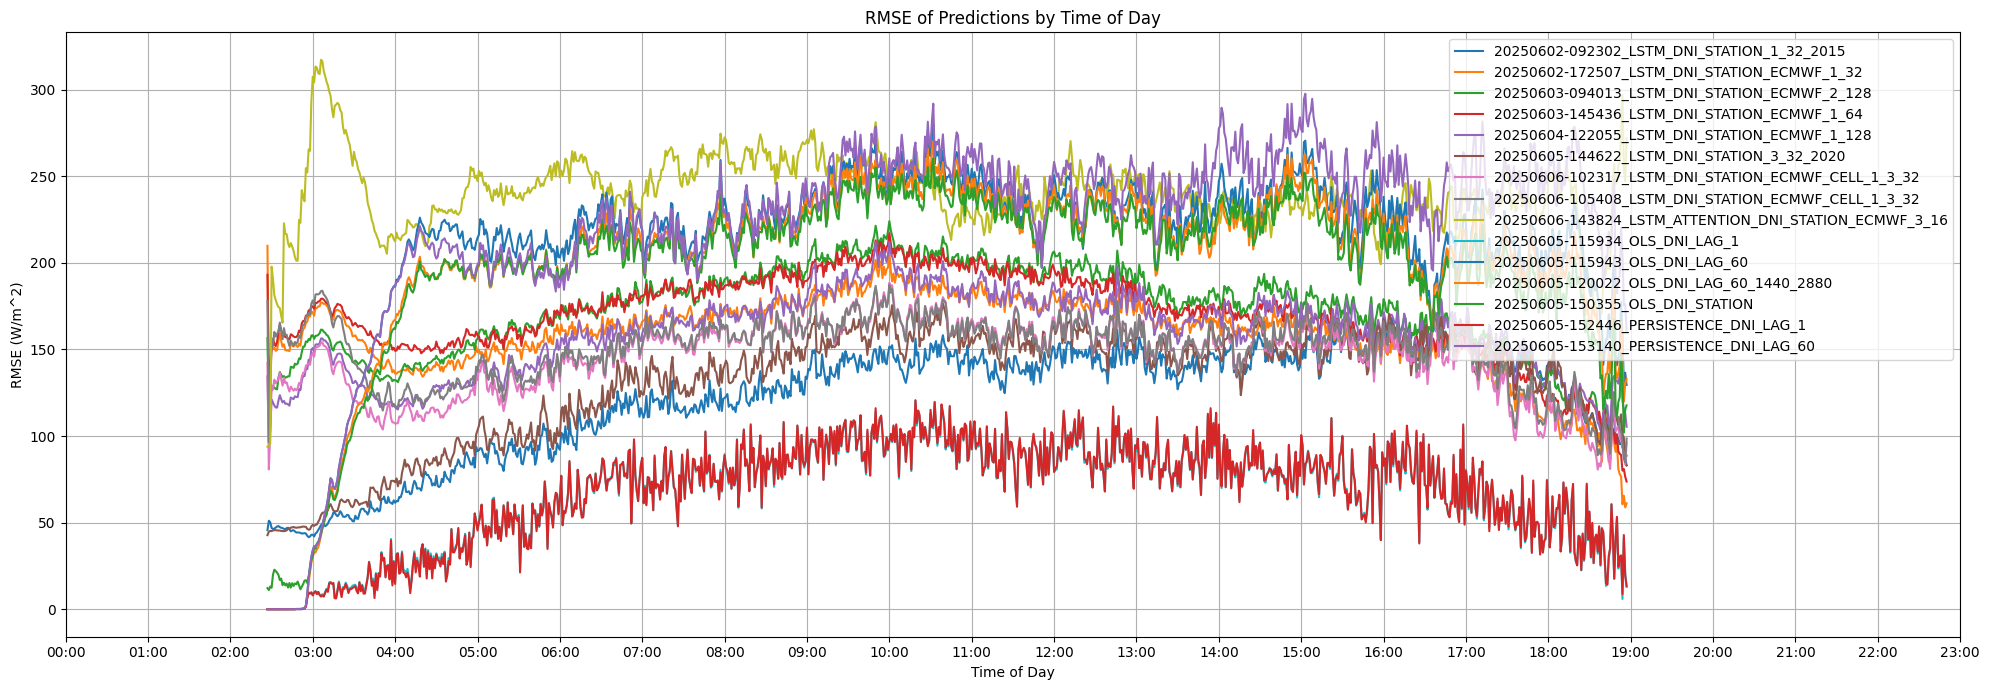

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 7))
comparsion.error_df['minute_of_day'] = comparsion.error_df.index.hour * 60 + comparsion.error_df.index.minute
for col in comparsion.error_df.columns:
    if col == 'minute_of_day':
        continue

    rmse_values = comparsion.error_df.groupby('minute_of_day')[col].apply(lambda x: (x**2).mean()**0.5)
    rmse_values.plot(ax=ax, ylabel='RMSE (W/m^2)', xlabel='Time of Day', label=col)
comparsion.error_df.drop(columns=['minute_of_day'], inplace=True)

ax.set_xticks(range(0, 1440, 60))  # Every hour
ax.set_xticklabels([f"{i // 60:02d}:{i % 60:02d}" for i in range(0, 1440, 60)], rotation=0)
ax.legend()
plt.title('RMSE of Predictions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('RMSE (W/m^2)')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

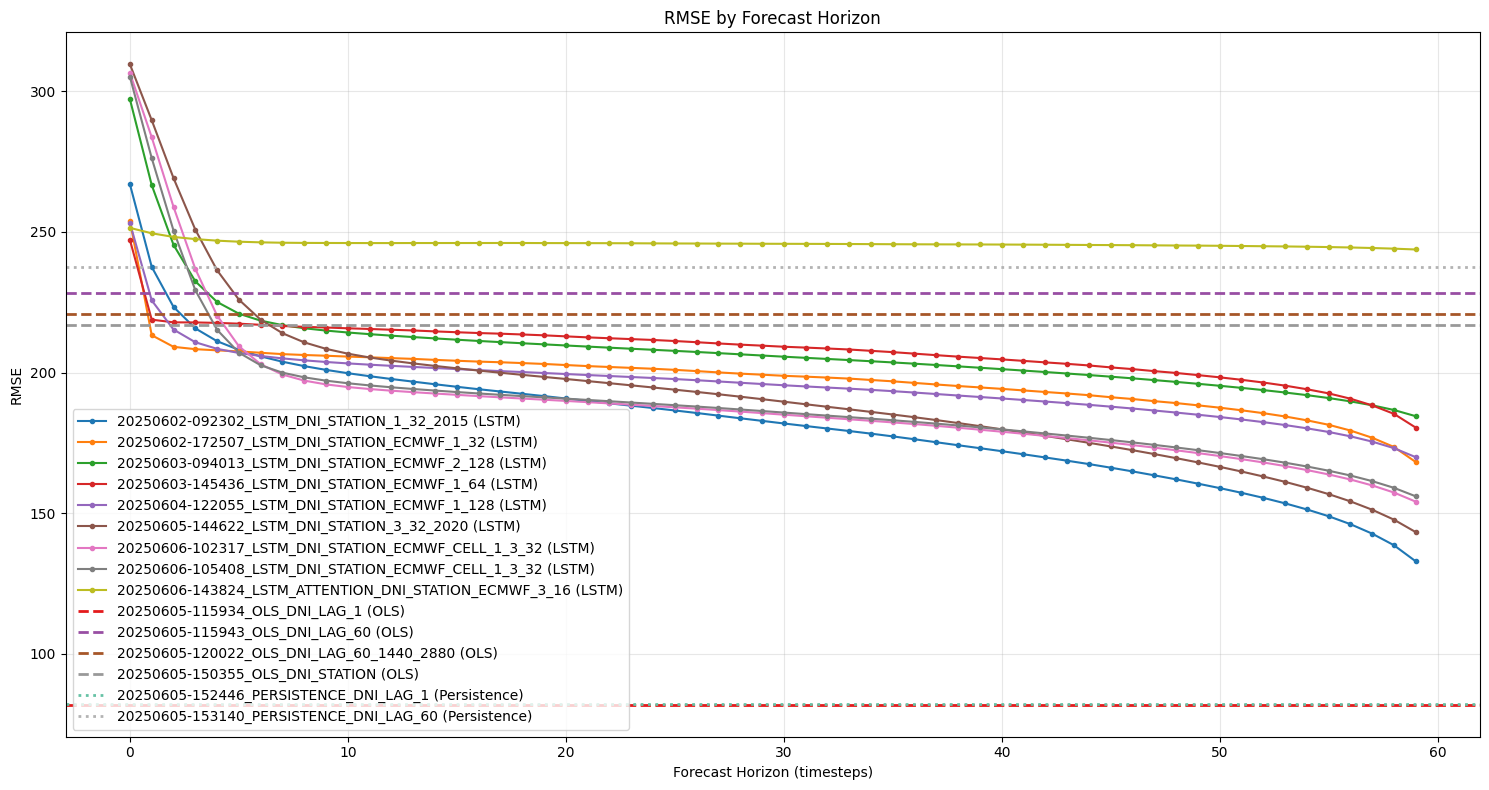

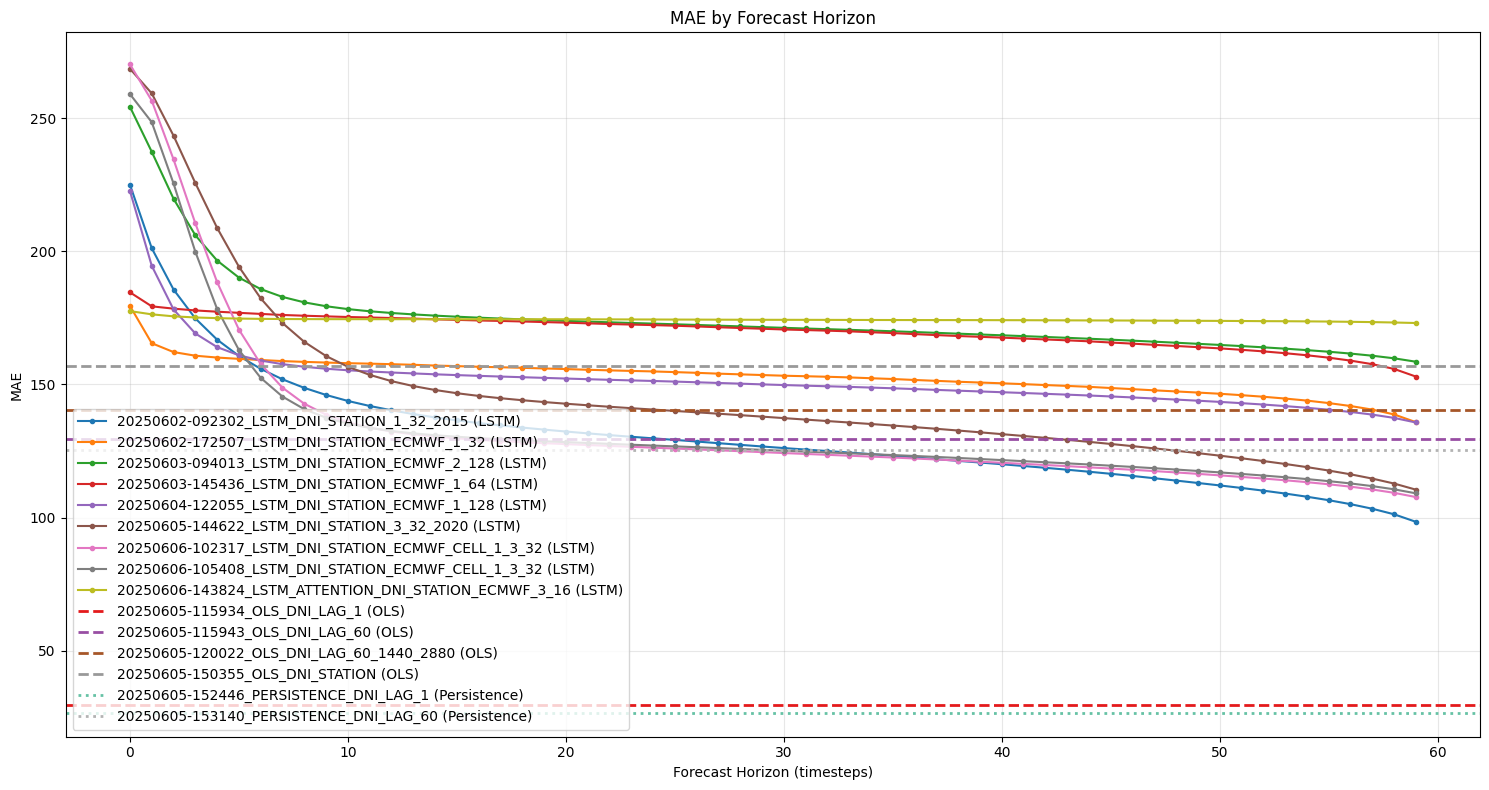

In [22]:
import numpy as np
def plot_model_metric_by_horizon(
    results: Results,
    target_key: str,
    metric_fn,
    metric_name: str,
    lstm_horizons: int = 60
):
    """
    Compute and plot a given metric (e.g. MAE, RMSE) for:
      • LSTM models (per‐horizon, 0..lstm_horizons−1)
      • OLS models (single value, plotted as horizontal line)
      • Persistence models (single value, horizontal line)

    Arguments:
        results       : ResultsContainer holding:
                          - results.results: list of Result objects
                          - results.truth[target_key]: pandas Series or array of true values
        target_key    : string key/column name in results.truth (e.g. 'TARGET')
        metric_fn     : function(truth_array, pred_array) → scalar metric
                        (e.g. MAE = lambda t,p: np.mean(np.abs(t-p)) )
        metric_name   : string, e.g. "MAE" or "RMSE". Used in labels/prints.
        lstm_horizons : int, number of horizons (default 60) for LSTM

    Returns:
        None. Displays a matplotlib figure and prints out summary stats.
    """
    # 1) Compute metric for each LSTM model per horizon:
    lstm_metric_by_timestep = {}
    for result in results.results:
        if result.model == ModelType.LSTM:
            model_name = result.absolute_path.parent.name
            mae_values = []
            for horizon in range(lstm_horizons):
                preds = result.df[horizon]
                truth_vals = results.truth[target_key]
                score = metric_fn(truth_vals.values, preds.values)
                mae_values.append(score)
            lstm_metric_by_timestep[model_name] = np.array(mae_values)

    # 2) Compute single metric for OLS and Persistence:
    ols_metric = {}
    persistence_metric = {}
    for result in results.results:
        if result.model == ModelType.OLS:
            model_name = result.absolute_path.parent.name
            preds = result.df[result.config.name]
            truth_vals = results.truth[target_key]
            score = metric_fn(truth_vals.values, preds.values)
            ols_metric[model_name] = score
        elif result.model == ModelType.PERSISTENCE:
            model_name = result.absolute_path.parent.name
            preds = result.df[result.config.name]
            truth_vals = results.truth[target_key]
            score = metric_fn(truth_vals.values, preds.values)
            persistence_metric[model_name] = score

    # 3) Plot everything
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(15, 8))

    # LSTM per‐horizon curves
    for model_name, metric_vals in lstm_metric_by_timestep.items():
        ax.plot(
            range(lstm_horizons),
            metric_vals,
            label=f"{model_name} (LSTM)",
            marker="o",
            markersize=3,
        )

    # OLS horizontal lines with different colors
    ols_colors = plt.cm.Set1(np.linspace(0, 1, len(ols_metric)))
    for i, (model_name, val) in enumerate(ols_metric.items()):
        ax.axhline(
            y=val,
            label=f"{model_name} (OLS)",
            linestyle="--",
            linewidth=2,
            color=ols_colors[i]
        )

    # Persistence horizontal lines with different colors
    persistence_colors = plt.cm.Set2(np.linspace(0, 1, len(persistence_metric)))
    for i, (model_name, val) in enumerate(persistence_metric.items()):
        ax.axhline(
            y=val,
            label=f"{model_name} (Persistence)",
            linestyle=":",
            linewidth=2,
            color=persistence_colors[i]
        )

    ax.set_xlabel("Forecast Horizon (timesteps)")
    ax.set_ylabel(f"{metric_name}")
    ax.set_title(f"{metric_name} by Forecast Horizon")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # # 4) Print summaries
    # # LSTM summary
    # if lstm_metric_by_timestep:
    #     print(f"LSTM {metric_name} by timestep:")
    #     for model_name, vals in lstm_metric_by_timestep.items():
    #         print(
    #             f"  {model_name}: "
    #             f"Min={vals.min():.4f}, Max={vals.max():.4f}, Mean={vals.mean():.4f}"
    #         )
    # else:
    #     print(f"No LSTM models found to compute {metric_name}.")

    # # OLS summary
    # if ols_metric:
    #     print(f"\nOLS {metric_name}:")
    #     for model_name, val in ols_metric.items():
    #         print(f"  {model_name}: {val:.4f}")
    # else:
    #     print(f"\nNo OLS models found to compute {metric_name}.")

    # # Persistence summary
    # if persistence_metric:
    #     print(f"\nPersistence {metric_name}:")
    #     for model_name, val in persistence_metric.items():
    #         print(f"  {model_name}: {val:.4f}")
    # else:
    #     print(f"\nNo Persistence models found to compute {metric_name}.")



plot_model_metric_by_horizon(
    results=results,
    target_key=TARGET,
    metric_fn=ForecastEvaluator.compute_rmse,
    metric_name="RMSE",
    lstm_horizons=60
)


plot_model_metric_by_horizon(
    results=results,
    target_key=TARGET,
    metric_fn=ForecastEvaluator.compute_mae,
    metric_name="MAE",
    lstm_horizons=60
)

# Sample plot predictions

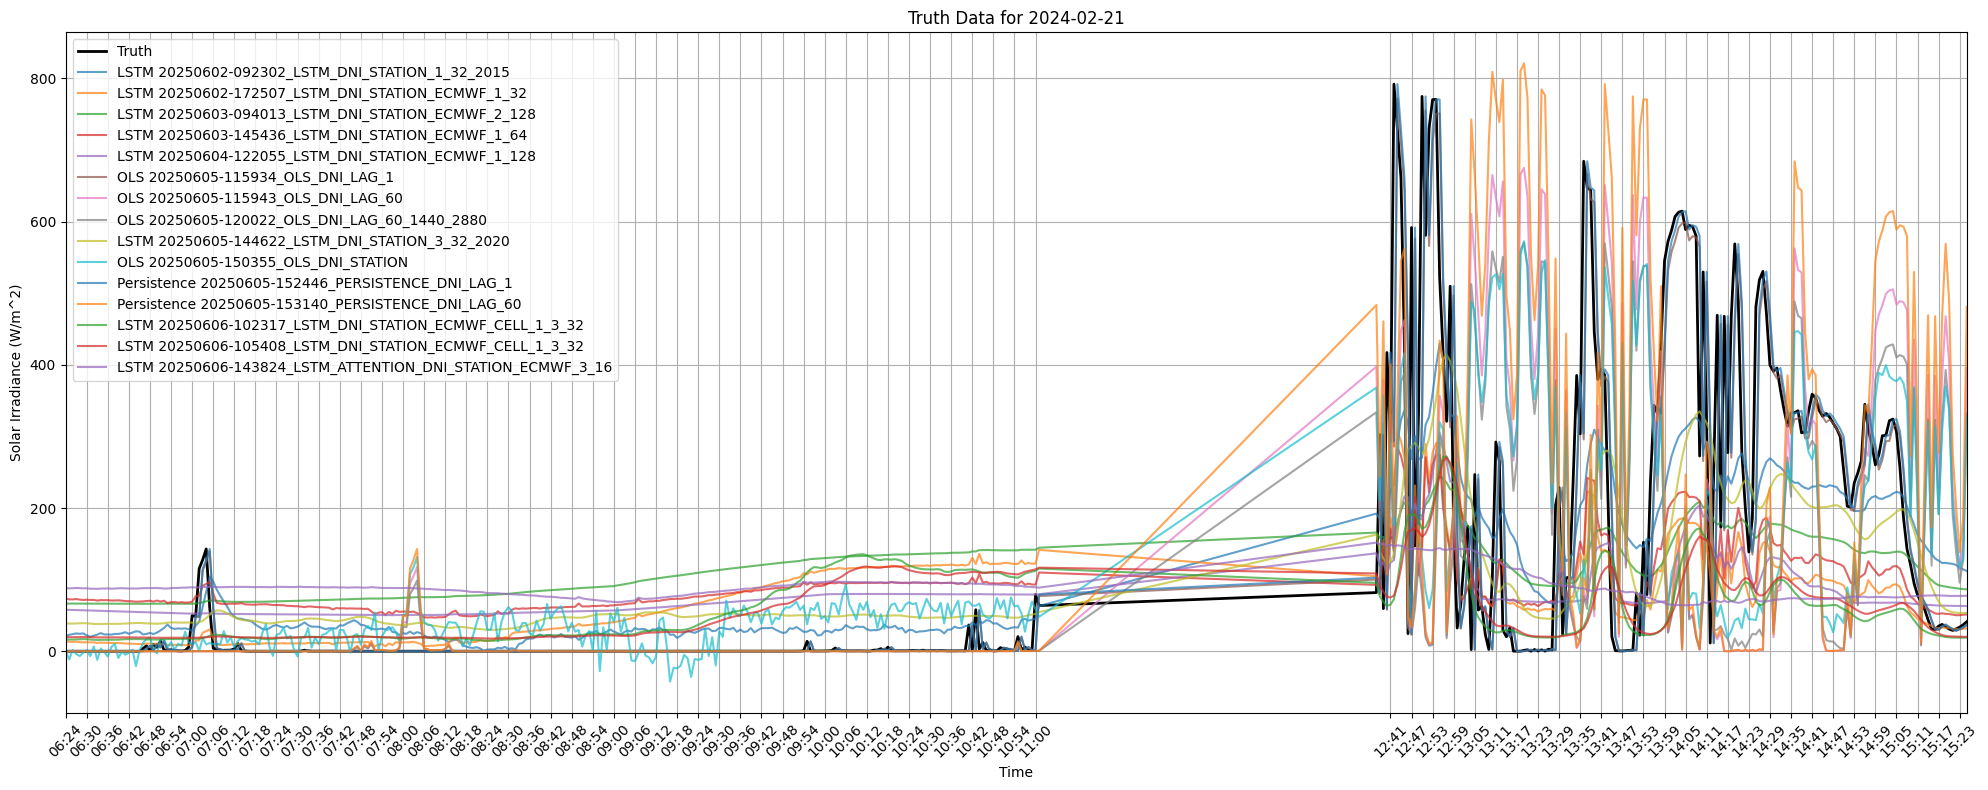

In [23]:
# Plot the truth data for a random date
import random
random_date = random.choice(results.truth.index).strftime('%Y-%m-%d')
truth_data = results.truth.loc[random_date]
plt.figure(figsize=(20, 8))
plt.plot(truth_data.index, truth_data.values, label='Truth', color='black', linewidth=2)
plt.title(f'Truth Data for {random_date}')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance (W/m^2)')
plt.xticks(rotation=45)
# human readable x-axis in format HH:MM
plt.xticks(truth_data.index[::6], [t.strftime('%H:%M') for t in truth_data.index[::6]], rotation=45)
# limit x-axis to the range of the truth data
plt.xlim(truth_data.index.min(), truth_data.index.max())

# Plot each model's predictions
for result in results.results:
    data = result.df.loc[random_date]
    if result.model == ModelType.LSTM:
        plt.plot(data.index, data.loc[:, 59], label=f'LSTM {result.absolute_path.parent.name}', alpha=0.7)
    elif result.model == ModelType.OLS:
        plt.plot(data.index, data[result.config.name], label=f'OLS {result.absolute_path.parent.name}', alpha=0.7)
    elif result.model == ModelType.PERSISTENCE:
        plt.plot(data.index, data[result.config.name], label=f'Persistence {result.absolute_path.parent.name}', alpha=0.7)

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



# Autocorrelation


In [24]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.stats.stattools import durbin_watson
# from statsmodels.stats.diagnostic import acorr_ljungbox

# # Compute residuals using the correct column names
# df = model_lstm_df.copy()
# df['residual'] = df['Error']

# # Compute autocorrelation values for the residuals up to lag 20
# from statsmodels.tsa.stattools import acf
# acf_values = acf(df['residual'], nlags=60, fft=True)
# lags = list(range(len(acf_values)))
# acf_df = pd.DataFrame({'lag': lags, 'acf': acf_values})
# # plot ACF values
# fig, ax = plt.subplots(figsize=(12, 6))
# acf_df.plot(x='lag', y='acf', kind='bar', ax=ax, legend=False)
# ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# ax.set_title('Autocorrelation Function (ACF) of Model Residuals')
# ax.set_xlabel('Lag')
# ax.set_ylabel('ACF Value')
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()
